## Introduction

Due to the NDA agreement, I created a mock dataset to avoid disclosing sensitive information. The topic of the notebook is also fictional but is still somewhat related to the original project. This notebook demonstrates some of the methods and approaches I used throughout the analysis, rather than the interpretations or performance results of the predictive model. Nevertheless, at the end of the notebook, you will find my notes on the challenges I faced and how I addressed them in the original project.

---------------------------------

**Project Goal:** The target of the project is enhancing the driving experience for the taxi customers in terms of the response time of the received demand. Achieving it heavily relies on efficiently optimizing the vehicles across the city, and reaching to the customer location as soon as the call is received from the customer.

**Dataset:** Dataset contains;

- Geographic information (latitude-longitude) of both customers and vehicles
- Date and time of the previous calls
- Call type (encoded)
- Taxi's station ID
- Approximate driving distance and driving time between car location and the demand location

In [1]:
import pandas as pd
import numpy as np
import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("MOCK_DATA.csv")

In [3]:
data.head()

,demand_id,demand_lat,demand_lon,Demand_received,Demand_reached,Demand_completed,Car_station,Call_type,Car_lat,Car_lon,DriveDistance,DriveTime
0,1,38.726110,-9.148583,08-09-2024 17:46,08-09-2024 18:18,08-09-2024 18:54,302,3,38.770309,-9.152437,4930.817188,5.916981
1,2,38.740174,-9.136456,10-23-2024 08:33,10-23-2024 08:38,10-23-2024 09:28,304,2,38.776012,-9.149431,4236.041635,5.083250
2,3,38.769426,-9.093147,11-28-2024 20:09,11-28-2024 20:16,11-28-2024 21:01,305,3,38.745006,-9.116998,3793.771745,4.552526
3,4,38.762938,-9.174401,07-28-2024 11:36,07-28-2024 11:59,07-28-2024 12:20,302,3,38.704859,-9.195044,6850.398480,8.220478
4,5,38.719571,-9.118927,09-22-2024 13:30,09-22-2024 13:49,09-22-2024 14:38,302,2,38.704519,-9.105115,2270.416490,2.724500


*Basic preprocessing steps were included in a separate .py file named preprocessing.py. Whenever the dataset is updated, this file is applied to prepare the data for the subsequent analysis steps.*

In [4]:
print(f'Original dataset size: {len(data)}')
preprocessing.main_processing(data)
print(f"Dataset size after preprocessing: {len(data)}")

Original dataset size: 1996
Basic preprocessing steps are executed...
drop_missing_latlong function is executed
The rows with missing latitude and longitude values are deleted

date_and_time_transformation function is executed

Receive time, reach time and completion time have been converted into datetime and timestamp format

calculate_arrive_time function function is executed
Arrive time is calculated by ReachTime - ReceivedTime

data_restriction_by_arrive_time function is executed
2 records have been eliminated due to exceeding the 2sigma limit
Dataset has been restricted according to the given standard deviation boundaries in Arrive Time feature

calculate_arrive_time function is executed
Arrive time is calculated by ReachTime - ReceivedTime

arrival time bins are created

create_time_components function is executed for T1
Time, date, day, month, year, hour, dayofweek components are created for Demand_received

Month-year concatenation has been created

priority_data_type function 

In [5]:
data.head()

,index,demand_id,demand_lat,demand_lon,Demand_received,Demand_reached,Demand_completed,Car_station,Call_type,Car_lat,...,Demand_time,Demand_date,Demand_day,Demand_month,Demand_year,Demand_hour,Demand_dayofweek,Demand_month_year,T1_month_year,daily_freq
0,0,1,38.726110,-9.148583,2024-08-09 17:46:00,2024-08-09 18:18:00,2024-08-09 18:54:00,302,3,38.770309,...,17:46:00,2024-08-09,9,8,2024,17,4,8-2024,2024-08-01,4
1,1,2,38.740174,-9.136456,2024-10-23 08:33:00,2024-10-23 08:38:00,2024-10-23 09:28:00,304,2,38.776012,...,08:33:00,2024-10-23,23,10,2024,8,2,10-2024,2024-10-01,2
2,2,3,38.769426,-9.093147,2024-11-28 20:09:00,2024-11-28 20:16:00,2024-11-28 21:01:00,305,3,38.745006,...,20:09:00,2024-11-28,28,11,2024,20,3,11-2024,2024-11-01,4
3,3,4,38.762938,-9.174401,2024-07-28 11:36:00,2024-07-28 11:59:00,2024-07-28 12:20:00,302,3,38.704859,...,11:36:00,2024-07-28,28,7,2024,11,6,7-2024,2024-07-01,2
4,4,5,38.719571,-9.118927,2024-09-22 13:30:00,2024-09-22 13:49:00,2024-09-22 14:38:00,302,2,38.704519,...,13:30:00,2024-09-22,22,9,2024,13,6,9-2024,2024-09-01,5


## EDA

*The describe() function is primarily used to check for potential outliers or insignificant deviations. However, since most of the data consists of date/time or location information, descriptive statistics do not provide much insight except the drive time and drive distance.*

In [6]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
index,1994.0,996.5,0.0,498.25,996.5,1494.75,1993.0,575.762538
demand_id,1994.0,1000.270812,1.0,500.25,998.5,1500.75,2000.0,577.689233
demand_lat,1994.0,38.745722,38.700022,38.723356,38.745817,38.768624,38.789884,0.025774
demand_lon,1994.0,-9.143802,-9.199955,-9.170353,-9.141651,-9.116756,-9.090055,0.031357
Demand_received,1994,2024-01-01 20:49:43.299899648,2023-01-01 06:01:00,2023-07-07 22:04:45,2023-12-28 19:17:00,2024-07-01 16:32:45,2024-12-24 22:38:00,NaN
Demand_reached,1994,2024-01-01 21:20:15.977933824,2023-01-01 06:15:00,2023-07-07 22:35:45,2023-12-28 19:58:00,2024-07-01 16:49:00,2024-12-24 23:25:00,NaN
Demand_completed,1994,2024-01-01 21:14:33.370110464,2023-01-01 06:30:00,2023-07-07 23:26:45,2023-12-28 16:36:30,2024-07-01 17:17:30,2024-12-24 23:54:00,NaN
Car_station,1994.0,302.433801,300.0,301.0,302.0,304.0,305.0,1.844121
Call_type,1994.0,2.347041,1.0,2.0,3.0,3.0,3.0,0.806349
Car_lat,1994.0,38.745325,38.700079,38.722574,38.745499,38.767698,38.78984,0.026162


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   index              1994 non-null   int64         
 1   demand_id          1994 non-null   int64         
 2   demand_lat         1994 non-null   float64       
 3   demand_lon         1994 non-null   float64       
 4   Demand_received    1994 non-null   datetime64[ns]
 5   Demand_reached     1994 non-null   datetime64[ns]
 6   Demand_completed   1994 non-null   datetime64[ns]
 7   Car_station        1994 non-null   int64         
 8   Call_type          1994 non-null   int64         
 9   Car_lat            1994 non-null   float64       
 10  Car_lon            1994 non-null   float64       
 11  DriveDistance      1994 non-null   float64       
 12  DriveTime          1994 non-null   float64       
 13  Arrive_time        1994 non-null   float64       
 14  arrive_d

In [8]:
#Checking the missing values
miss_val = data.isnull().sum()
miss_val=miss_val.drop(miss_val[miss_val == 0].index).sort_values(ascending = False)
pd.DataFrame({'Missing Values':miss_val, 'Percent':round(miss_val/len(data),2)*100})

,Missing Values,Percent


In [9]:
data['arrive_data_bins'].value_counts()

arrive_data_bins
44.0-48.0    188
20.0-24.0    180
48.0-52.0    170
52.0-56.0    168
40.0-44.0    162
32.0-36.0    157
8.0-12.0     150
12.0-16.0    143
24.0-28.0    139
16.0-20.0    137
28.0-32.0    136
36.0-40.0    134
4.0-8.0      130
Name: count, dtype: int64

*The mock dataset mostly consists of a balanced distribution of data. Therefore, the visualizations in the notebook do not provide clear insights into the data itself. However, in the actual project, the following methods and graphs were used for a clearer analysis of historical arrival times. The times were divided into bins with a 4-minute range and compared to the target arrival times set by the company.*

C:\Users\emrey\AppData\Local\Temp\ipykernel_14244\2856574175.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='arrive_data_bins', order=bins_order, palette='viridis')


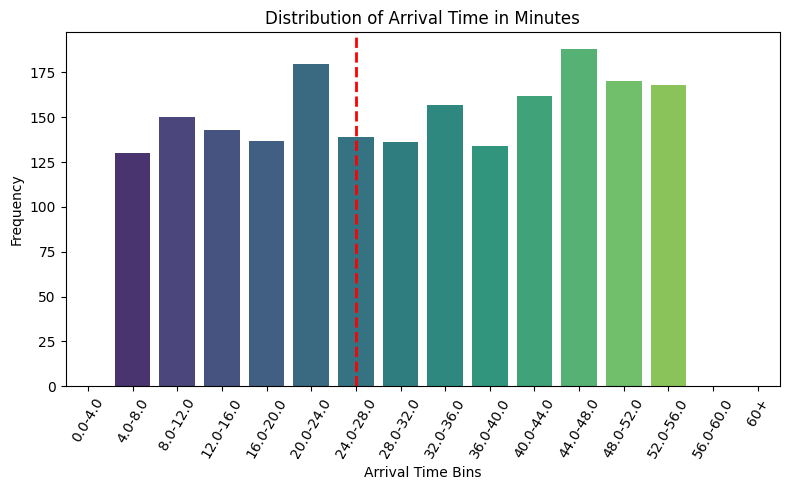

In [10]:
bins_order = np.array(['0.0-4.0', '4.0-8.0','8.0-12.0','12.0-16.0', '16.0-20.0', '20.0-24.0', '24.0-28.0',
       '28.0-32.0', '32.0-36.0', '36.0-40.0',  '40.0-44.0',
       '44.0-48.0', '48.0-52.0', '52.0-56.0', '56.0-60.0', '60+'])

aimed_arrival_time = '24.0-28.0'

fig = plt.figure(figsize=(8,5))
sns.countplot(data=data, x='arrive_data_bins', order=bins_order, palette='viridis')
plt.title("Distribution of Arrival Time in Minutes")
plt.xlabel("Arrival Time Bins")
plt.ylabel("Frequency")
plt.xticks(rotation=60)
plt.axvline(x=aimed_arrival_time, color='red', linestyle='--', linewidth=2, label='Aimed Arrival Time')
plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

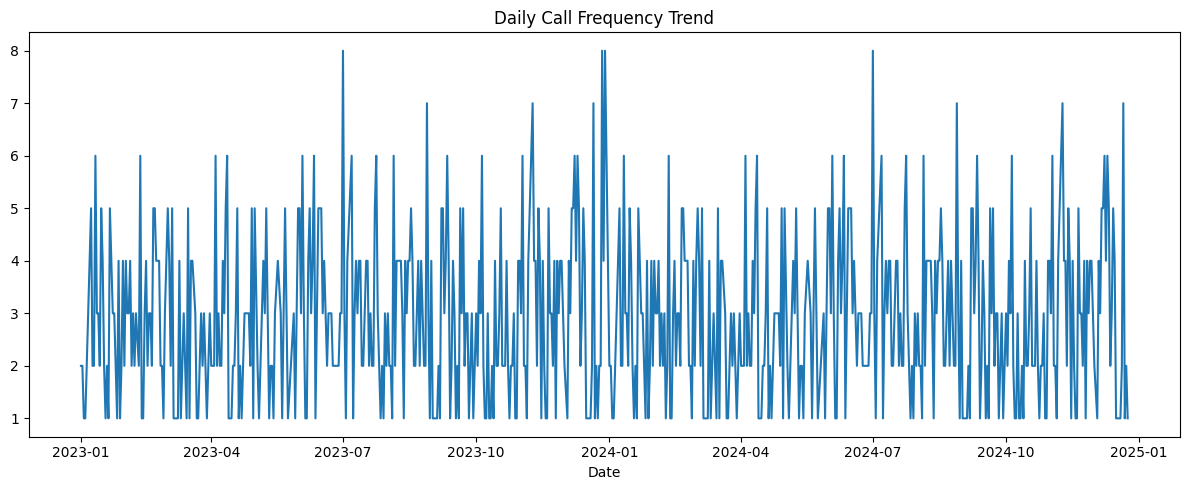

In [11]:
#Creating new column with daily frequency
daily_call=data.groupby(by="Demand_date")['demand_id'].count()
daily_call_map=dict(zip(daily_call.index, daily_call.values))

fig=plt.figure(figsize=(12,5))
daily_call.plot()
plt.title("Daily Call Frequency Trend")
plt.xlabel("Date")
plt.tight_layout()
plt.show

In [12]:
print(f"Number of max call in a day: {daily_call.max()}")
print(f"Number of min call in a day: {daily_call.min()}")
print(f"Number of average call in a day: {round(daily_call.mean(),0)}")

Number of max call in a day: 8
Number of min call in a day: 1
Number of average call in a day: 3.0


*Since the dataset contains date-time information, time-series analysis tools are invaluable for the analysis. The seasonality plot and decomposition reveal insights into historical events and their time-based frequency.*

**Seasonality Plot** illustrates the distribution of past demand over the years. Although the mock dataset contains only two years of data, in the original dataset, this visualization helped identify similar monthly trends across different years.

**Decomposition** supports the analysis of seasonality by providing detailed insights into the trend, seasonal effects, and the behavior of residuals, including their normality. 

For instance, if there is a seasonal effect, removing it may provide clearer insights into the trend. Alternatively, the seasonal component could be used in forecasting by encoding it with cyclic features, such as sine-cosine transformations.

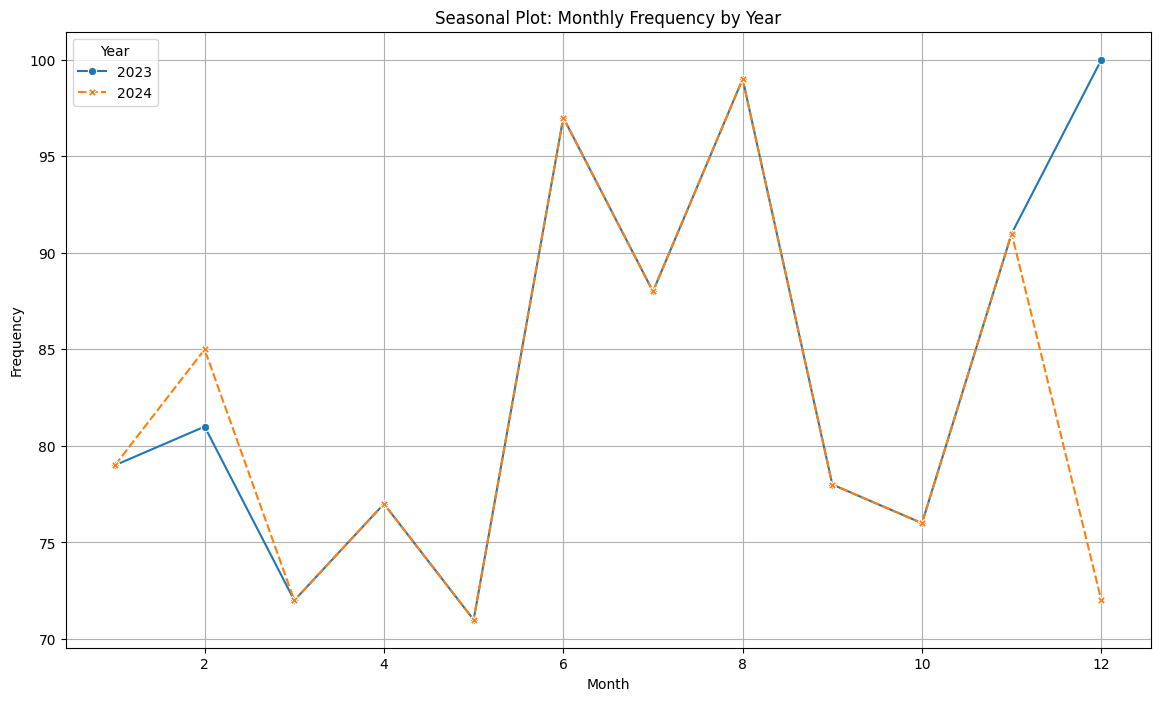

In [13]:
#Seasonal plot
monthly_counts = data.groupby(['Demand_year', 'Demand_month']).size().reset_index(name='count')
monthly_counts

pivot_table = monthly_counts.pivot(index='Demand_month', columns='Demand_year', values='count')
pivot_table

plt.figure(figsize=(14, 8))
sns.lineplot(data=pivot_table, markers=True)
plt.title('Seasonal Plot: Monthly Frequency by Year')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.legend(title='Year')
plt.grid(True)
plt.show()

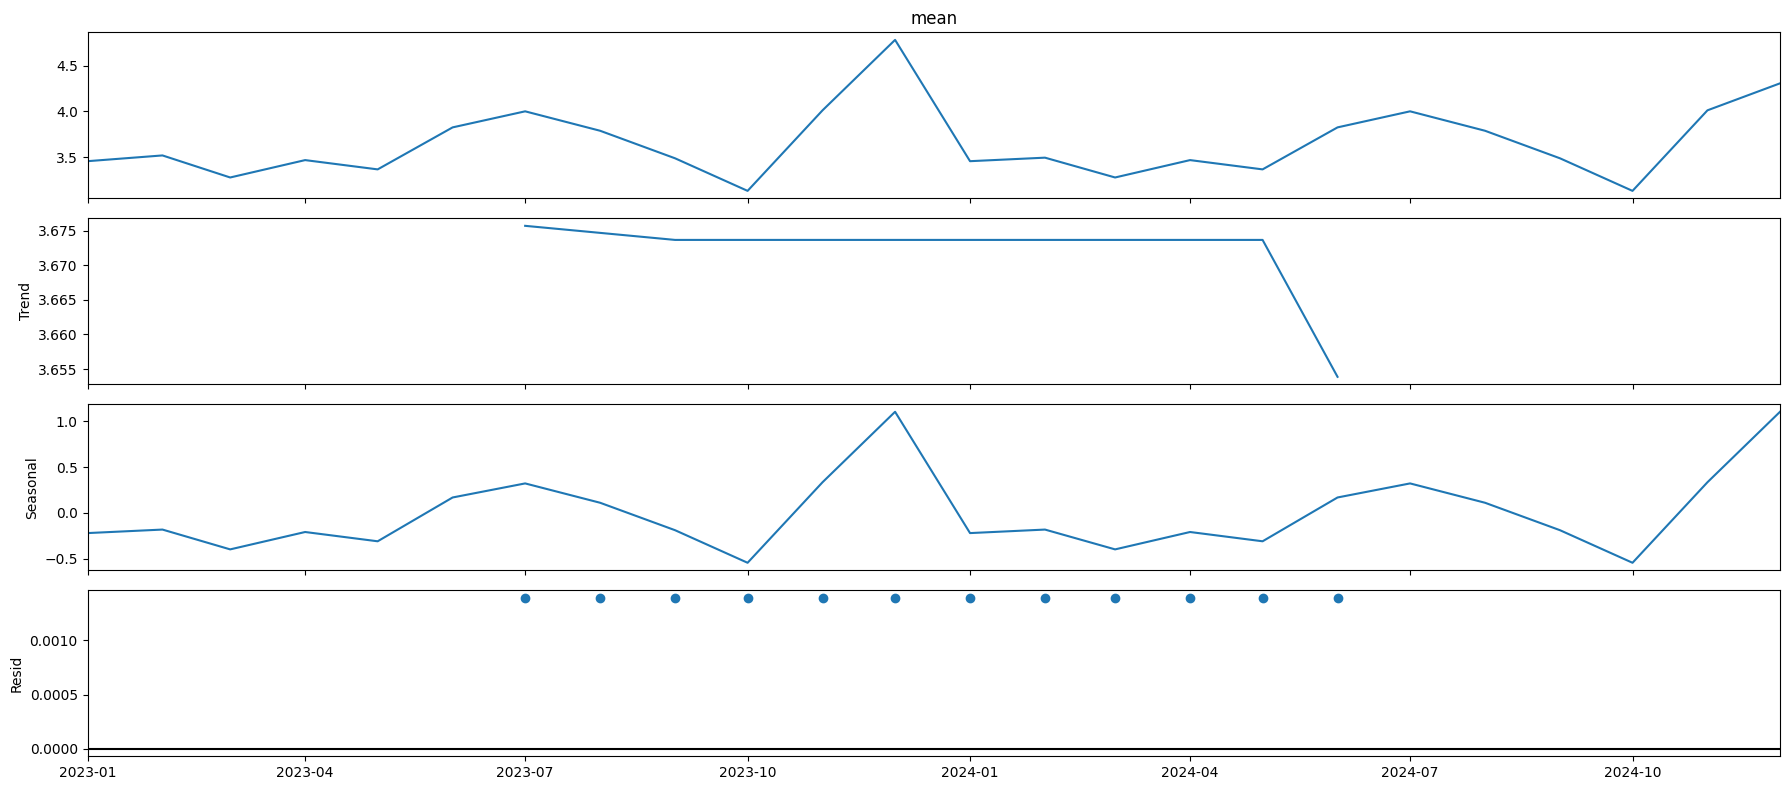

In [14]:
#Decomposing the time-series into 3 components: Trend, Seasonality and Noise
from pylab import rcParams
import statsmodels.api as sm
monthly_average = data.groupby('Demand_month_year')['daily_freq'].agg(["mean"]).reset_index()

# 1. Convert 'Demand_month_year' to datetime
monthly_average['Demand_month_year'] = pd.to_datetime(monthly_average['Demand_month_year'], format='%m-%Y')

# 2. Set 'Demand_month_year' as the index
monthly_average = monthly_average.set_index('Demand_month_year')

y = monthly_average['mean'].resample('MS').mean()

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The following graphing function was created to be used frequently with different features in the original project. However, since the mock dataset contains only a few features, it is used only once in this demonstration.

In [15]:
#Graph Functions
def plot_func(data, main_col,  ax=None, graph_type="bar"):
    """_summary_

    Args:
        data (DataFrame): main dataset in dataframe format
        main_col (str): name of the feature that will be visualized
        ax (float, optional): to adjust the axis values if needed. Defaults to None.
        graph_type (str, optional): Either bar graph or line graph options. Defaults to "bar".
    """
    if (graph_type.lower()=="bar")|(graph_type.lower()=='line'):
        
        temp_df=data[[main_col]]
        if graph_type =="line":
            sns.lineplot(y=temp_df[main_col].value_counts(),
                        x=temp_df[main_col].value_counts().index, ax=ax)
            if ax ==None:
                plt.gca().set_ylim(temp_df[main_col].value_counts().min(), temp_df[main_col].value_counts().max())
            else: 
                ax.set_ylim(temp_df[main_col].value_counts().min(), temp_df[main_col].value_counts().max())
        else:
            sns.barplot(y=temp_df[main_col].value_counts(),
                        x=temp_df[main_col].value_counts().index, ax=ax, palette='viridis')
        plt.title(f'{main_col} Trend Graph')
    else:
        return "Graph type should be either bar or line"


C:\Users\emrey\AppData\Local\Temp\ipykernel_14244\785608308.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=temp_df[main_col].value_counts(),


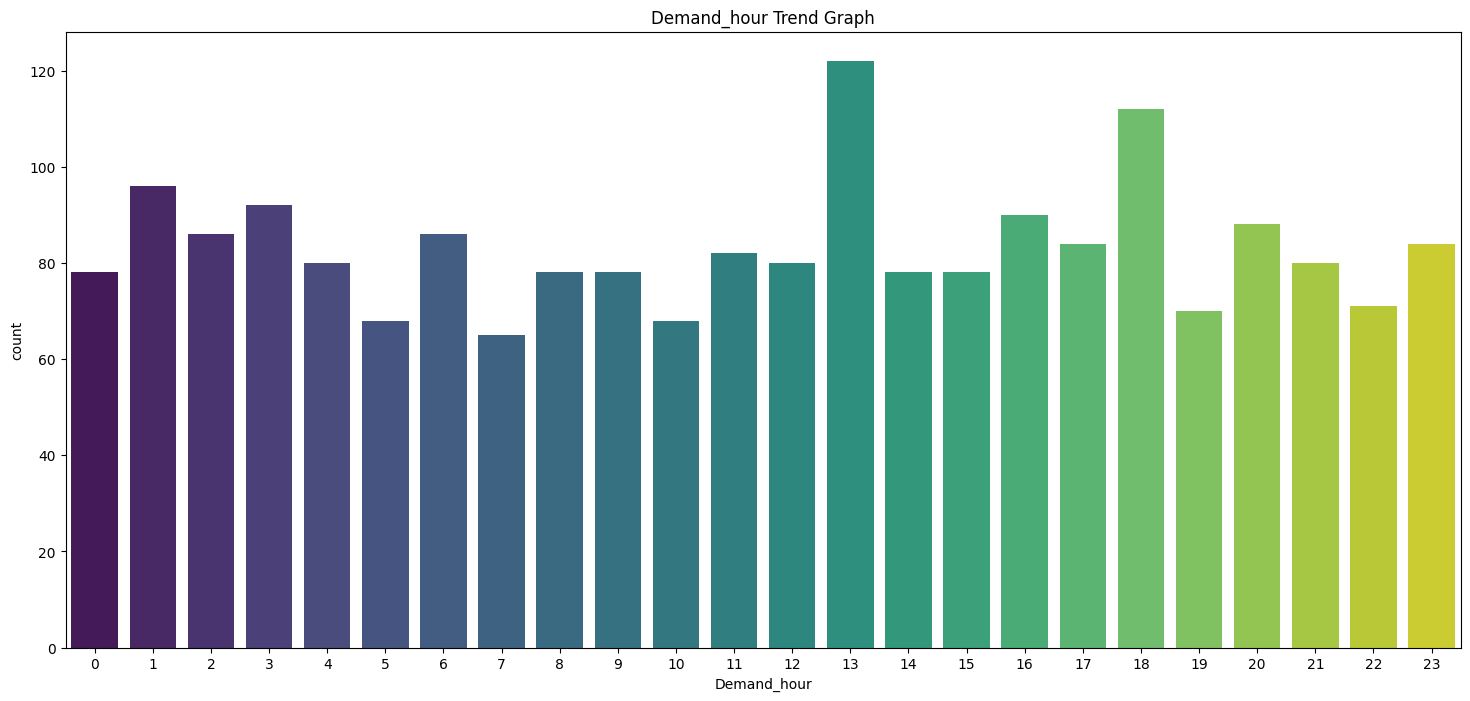

In [16]:
plot_func(data=data,main_col='Demand_hour')

In [17]:
data.loc[data[(data['Demand_hour']<=5) &(data['Demand_hour']>=0)].index,'TimeofDay']='Early_Morning'
data.loc[data[(data['Demand_hour']<=11) &(data['Demand_hour']>=6)].index,'TimeofDay']='Morning'
data.loc[data[(data['Demand_hour']<=17) &(data['Demand_hour']>=12)].index,'TimeofDay']='Afternoon'
data.loc[data[(data['Demand_hour']<=23) &(data['Demand_hour']>=18)].index,'TimeofDay']='Evening/Midnight'

In [18]:
round(data[data['Call_type'].isin([2,3])].groupby(by=['Call_type','TimeofDay'])[['DriveTime', 'DriveDistance']].mean(),2)

DriveTime  DriveDistance
Call_type TimeofDay                                 
2         Afternoon              6.78        5649.36
          Early_Morning          7.23        6027.07
          Evening/Midnight       7.23        6024.65
          Morning                7.30        6080.71
3         Afternoon              7.44        6202.70
          Early_Morning          6.86        5716.95
          Evening/Midnight       7.41        6172.13
          Morning                6.71        5594.38

## K-Means Clustering Based on The Time of The Day

**K-Means clustering** is primarily used in unsupervised learning to group similar data points based on their characteristics.

*In this project, K-Means clustering was applied to analyze whether there are similar regions in terms of call frequency. The dataset was also clustered based on the time of day to investigate whether similarities change during different periods of the day.*

*The uniqueness of this approach lies in using the ***BallTree*** algorithm alongwith ***Haversine*** distance calculation to identify neighboring points within a given radius, incorporating them as clustering weights for more efficient clustering.*

In [19]:
from sklearn.neighbors import BallTree
from sklearn.cluster import KMeans
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [20]:
cluster_data_early_morning = data[data['TimeofDay']=='Early_Morning']
print(len(data))
print(len(cluster_data_early_morning))

cluster_data_day = data[data['TimeofDay']!='Early_Morning']
print(len(data))
print(len(cluster_data_day))

1994
500
1994
1494


In [21]:
cluster_data_early_morning=cluster_data_early_morning.loc[:,['demand_lat','demand_lon']]

cluster_data_day=cluster_data_day.loc[:,['demand_lat','demand_lon']]

In [22]:
cluster_data_early_morning['demand_lat_rad'] = np.deg2rad(cluster_data_early_morning['demand_lat'])
cluster_data_early_morning['demand_lon_rad'] = np.deg2rad(cluster_data_early_morning['demand_lon'])

cluster_data_day['demand_lat_rad'] = np.deg2rad(cluster_data_day['demand_lat'])
cluster_data_day['demand_lon_rad'] = np.deg2rad(cluster_data_day['demand_lon'])

In [23]:
coords_early_morning = cluster_data_early_morning[['demand_lat_rad', 'demand_lon_rad']].values
tree_early_morning = BallTree(coords_early_morning, metric='haversine')

coords_day = cluster_data_day[['demand_lat_rad', 'demand_lon_rad']].values
tree_day = BallTree(coords_day, metric='haversine')

In [24]:
radius_km = 5
# Convert radius to radians
radius = radius_km / 6371.0  # Earth's radius in kilometers

# Query for neighbors within the specified radius
# Each point queries itself, so it will be included in its own neighbor count
neighbors_count_early_morning = tree_early_morning.query_radius(coords_early_morning, r=radius, count_only=True)
neighbors_count_day = tree_day.query_radius(coords_day, r=radius, count_only=True)

# Subtract one to exclude the point itself from its neighbor count
neighbors_count_early_morning = neighbors_count_early_morning - 1
neighbors_count_day = neighbors_count_day - 1

# Add the result to the dataframe
cluster_data_early_morning['neighbors_count'] = neighbors_count_early_morning
cluster_data_day['neighbors_count'] = neighbors_count_day

In [25]:
cluster_data_early_morning.drop_duplicates(inplace=True)
cluster_data_day.drop_duplicates(inplace=True)

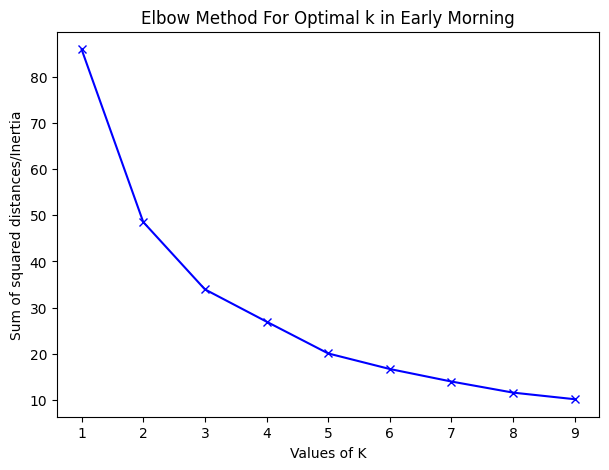

In [26]:
X_early_morning=np.array(cluster_data_early_morning[['demand_lat','demand_lon']])
y_early_morning=np.array(cluster_data_early_morning['neighbors_count'])

X_day=np.array(cluster_data_day[['demand_lat','demand_lon']])
y_day=np.array(cluster_data_day['neighbors_count'])


Sum_of_squared_distances_early_morning = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters, random_state=0, max_iter=1000)
    kmeans.fit(X_early_morning, sample_weight=y_early_morning)
    Sum_of_squared_distances_early_morning.append(kmeans.inertia_)
fig=plt.figure(figsize=(7,5))
plt.plot(K,Sum_of_squared_distances_early_morning,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k in Early Morning')
plt.show()

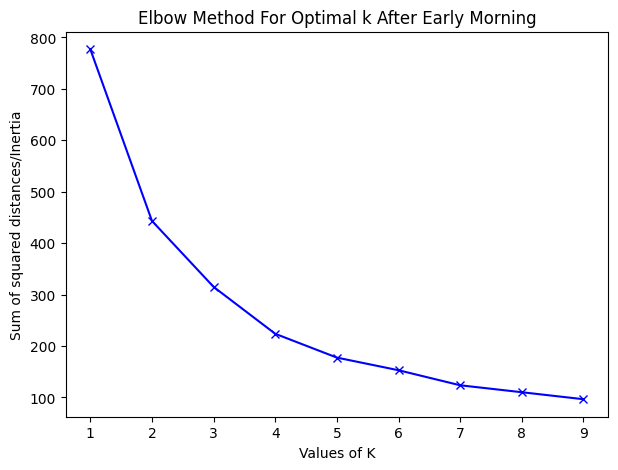

In [27]:
Sum_of_squared_distances_day = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters, random_state=0, max_iter=1000)
    kmeans.fit(X_day, sample_weight=y_day)
    Sum_of_squared_distances_day.append(kmeans.inertia_)
fig=plt.figure(figsize=(7,5))
plt.plot(K,Sum_of_squared_distances_day,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k After Early Morning')
plt.show()

In [28]:
kmeans_early_morning = KMeans(n_clusters=4, random_state=0, max_iter=1000)

X_early_morning=np.array(cluster_data_early_morning[['demand_lat','demand_lon']])
y_early_morning=np.array(cluster_data_early_morning['neighbors_count'])

wt_kmeansclus_early_morning = kmeans_early_morning.fit(X_early_morning,sample_weight = y_early_morning)

predicted_kmeans_early_morning = kmeans_early_morning.predict(X_early_morning)




kmeans_day = KMeans(n_clusters=4, random_state=0, max_iter=1000)

X_day=np.array(cluster_data_day[['demand_lat','demand_lon']])
y_day=np.array(cluster_data_day['neighbors_count'])

wt_kmeansclus_day = kmeans_day.fit(X_day,sample_weight = y_day)

predicted_kmeans_day = kmeans_day.predict(X_day)

In [29]:
cluster_data_early_morning['clusters']=predicted_kmeans_early_morning
cluster_data_day['clusters']=predicted_kmeans_day

print(cluster_data_early_morning['clusters'].value_counts())
print(cluster_data_day['clusters'].value_counts())

clusters
0    90
3    56
2    54
1    50
Name: count, dtype: int64
clusters
1    207
3    192
0    181
2    169
Name: count, dtype: int64


*For the map visualization of the clusters, the Cartopy library was used. Although the Folium library offers more dynamic visualizations, a more static environment is preferable for investigating clusters. Additionally, setting up the map environment is relatively easier with Cartopy compared to Folium. However, Folium is still used in the following sections where more dynamic visualizations are required.*

*Due to the balanced distribution in the mock dataset, the data points were divided into clusters almost equally. In the original dataset, however, this approach provided a much clearer illustration of the more important areas in terms of received calls in different periods of day.*

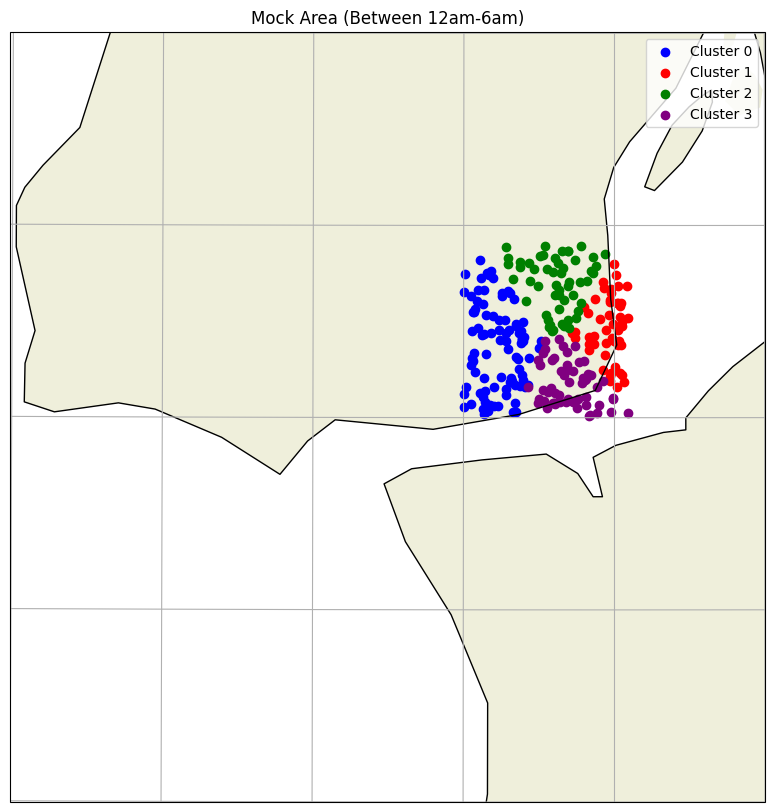

In [30]:
# Define Lambert Conformal projection centered on the area
proj = ccrs.LambertConformal(central_longitude=-9.1, central_latitude=38.7)

fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': proj})
# Add map features such as coastlines, states/provinces, etc.
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax.add_feature(cfeature.BORDERS.with_scale('10m'))
ax.add_feature(cfeature.LAKES.with_scale('10m'))
ax.add_feature(cfeature.RIVERS.with_scale('10m'))
ax.add_feature(cfeature.LAND.with_scale('10m'))

ax.set_extent([-9.5, -9, 38.5, 38.9], crs=ccrs.PlateCarree())

ax.set_title('Mock Area (Between 12am-6am)')

cluster_colors = {
    0: 'blue',
    1: 'red',
    2: 'green',
    3: 'purple'
    #4: 'cyan'
}

# Plot the coordinates for each cluster
for cluster_label, color in cluster_colors.items():
    cluster_points_early_morning = cluster_data_early_morning[cluster_data_early_morning['clusters'] == cluster_label]
    ax.scatter(cluster_points_early_morning['demand_lon'], cluster_points_early_morning['demand_lat'], color=color, marker='o', label=f'Cluster {cluster_label}', transform=ccrs.PlateCarree())

# Add legend
ax.legend()

ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)
plt.show()





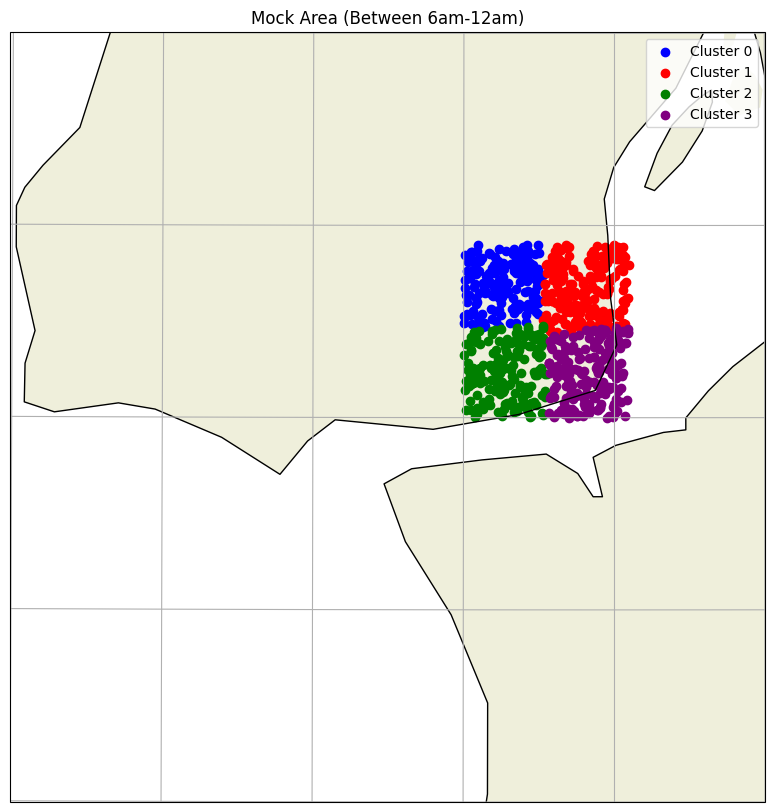

In [32]:
# Define Lambert Conformal projection centered on the area
proj = ccrs.LambertConformal(central_longitude=-9.1, central_latitude=38.7)

fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': proj})
# Add map features such as coastlines, states/provinces, etc.
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax.add_feature(cfeature.BORDERS.with_scale('10m'))
ax.add_feature(cfeature.LAKES.with_scale('10m'))
ax.add_feature(cfeature.RIVERS.with_scale('10m'))
ax.add_feature(cfeature.LAND.with_scale('10m'))

ax.set_extent([-9.5, -9, 38.5, 38.9], crs=ccrs.PlateCarree())

ax.set_title('Mock Area (Between 6am-12am)')

cluster_colors = {
    0: 'blue',
    1: 'red',
    2: 'green',
    3: 'purple'
    #4: 'cyan'
}

# Plot the coordinates for each cluster
for cluster_label, color in cluster_colors.items():
    cluster_points_day = cluster_data_day[cluster_data_day['clusters'] == cluster_label]
    ax.scatter(cluster_points_day['demand_lon'], cluster_points_day['demand_lat'], color=color, marker='o', label=f'Cluster {cluster_label}', transform=ccrs.PlateCarree())

# Add legend
ax.legend()

ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)
plt.show()





### HeatMap Visualization

*As mentioned earlier, the Folium library offers dynamic and highly customizable mapping visualizations. A heatmap is used to highlight areas of high demand.*

In [33]:
import folium
from folium.plugins import HeatMap

In [34]:
map_data=data.loc[:,['demand_lat','demand_lon','TimeofDay']]

In [ ]:
#Map Plotting With Folium

fig=plt.figure(figsize=(3,3))
time_of_day_map=map_data.loc[map_data[map_data['TimeofDay']=='Morning'].index,["demand_lat","demand_lon"]]
#single_day=map_data_single_day.loc[map_data_single_day[map_data_single_day['TimeofDay']=='Morning'].index,["demand_lat","demand_lon"]]

m = folium.Map(location=[time_of_day_map['demand_lat'].mean(), 
                         time_of_day_map['demand_lon'].mean()], 
               zoom_start=12.5)

#Create A Heatmap
heat_data = [[row['demand_lat'], row['demand_lon']] for index, row in time_of_day_map.iterrows()]
HeatMap(heat_data).add_to(m)

#Mark the spots
#for idx, row in single_day.iterrows():
#    folium.Marker([row['demand_lat'], row['demand_lon']]).add_to(m)

m

**Note**

Interactive maps are not visible in GitHub, therefore; a screenshot from the Folium map is shared below

![heatmap_ss](heatmap_ss.png)

## Creating The Grids

*To predict future demand in a spatio-temporal environment, granularity plays a crucial role. Efficient vehicle positioning and maximizing area coverage are key to achieving the ultimate goal of enhancing the customer driving experience. Therefore, instead of using clusters to predict time-based future demand, dividing the area into smaller sections can help optimize vehicle positioning. Although this approach may increase imbalance in the dataset, it provides a more precise foundation for optimization.*

*To divide the area into grids, the GeoPandas library was utilized. For spatial data manipulation, the DataFrame must be converted into a GeoDataFrame, a specialized data structure in GeoPandas designed to handle geometric objects such as points, lines, and polygons. GeoPandas also offers coordinate system conversions for more accurate calculations by considering the Earth's shape based on the analysis. In our case, since the area in the mock dataset is located in Lisbon, the coordinate system should be converted from EPSG:4326 to EPSG:32629.*

**source:** https://epsg.io/32629

In [44]:
import geo_custom_functions as gcf
import geopandas as gpd
import branca.colormap as cm
from branca.colormap import linear

In [121]:
#Creating the geographic dataframe with the coordinates in 'Point' data format
geo_df = gcf.create_geodf(data,geom_type='point', lon_col='demand_lon',lat_col='demand_lat')


#Set the correct crs codes for the emergency dataset
geo_df=geo_df.set_crs(epsg=4326)
geo_df=geo_df.to_crs(epsg=32629)

In [123]:
#Create the grid cells (grid_size_in_meters defines the length of one edge of the grid in meters)
grid_cells_polygon,grid_cells_x_ax,grid_cells_y_ax=gcf.create_grid_cells(geo_df, grid_size_in_meters=2000)
x_y_ax_df=pd.DataFrame({"x_ax":grid_cells_x_ax,
                        "y_ax":grid_cells_y_ax})

In [124]:
grid_cells_gdf=gcf.create_geodf(grid_cells_polygon, geom_type='polygon',crs=32629)
grid_cells_gdf.drop(0, axis=1,inplace=True)
grid_cells_gdf.reset_index(inplace=True)
grid_cells_gdf.rename(columns={'index':'grid_id'}, inplace=True)

In [125]:
grid_cells_gdf = pd.concat([grid_cells_gdf,x_y_ax_df],axis=1)

geo_df_with_grids = gpd.sjoin(geo_df, grid_cells_gdf, how='left', predicate='within')

In [126]:
cols_in_use=['Demand_received','Demand_time','Demand_date','Demand_day','Demand_month','Demand_year','Demand_hour','Demand_dayofweek','grid_id','x_ax','y_ax','demand_lat','demand_lon']
geo_df_with_grids=geo_df_with_grids[cols_in_use] 
geo_df_with_grids.head()

,Demand_received,Demand_time,Demand_date,Demand_day,Demand_month,Demand_year,Demand_hour,Demand_dayofweek,grid_id,x_ax,y_ax,demand_lat,demand_lon
0,2024-08-09 17:46:00,17:46:00,2024-08-09,9,8,2024,17,4,20.0,3.0,2.0,38.726110,-9.148583
1,2024-10-23 08:33:00,08:33:00,2024-10-23,23,10,2024,8,2,21.0,3.0,3.0,38.740174,-9.136456
2,2024-11-28 20:09:00,20:09:00,2024-11-28,28,11,2024,20,3,34.0,5.0,4.0,38.769426,-9.093147
3,2024-07-28 11:36:00,11:36:00,2024-07-28,28,7,2024,11,6,16.0,2.0,4.0,38.762938,-9.174401
4,2024-09-22 13:30:00,13:30:00,2024-09-22,22,9,2024,13,6,26.0,4.0,2.0,38.719571,-9.118927


### Draw The Grids

In [127]:
calls_in_grids = pd.DataFrame(geo_df_with_grids.groupby(by='grid_id').size())
calls_in_grids.rename(columns={0:"Number_of_Calls"},inplace=True)
calls_in_grids.head()

,Number_of_Calls
grid_id,
7.0,72
8.0,69
9.0,77
10.0,72
11.0,86


In [128]:
merged_grid = pd.merge(grid_cells_gdf,calls_in_grids, left_on='grid_id', right_on=['grid_id'], how='left')
merged_grid.drop(['x_ax','y_ax'],axis=1,inplace=True)
merged_grid.head()

,grid_id,geometry,Number_of_Calls
0,0,"POLYGON ((482615.555 4281496.274, 482615.555 4...",NaN
1,1,"POLYGON ((482615.555 4283496.274, 482615.555 4...",NaN
2,2,"POLYGON ((482615.555 4285496.274, 482615.555 4...",NaN
3,3,"POLYGON ((482615.555 4287496.274, 482615.555 4...",NaN
4,4,"POLYGON ((482615.555 4289496.274, 482615.555 4...",NaN


In [129]:
merged_grid.to_crs(epsg=4326, inplace=True)

In [ ]:
# Create a color scale based on the Number_of_Calls
max_calls = merged_grid['Number_of_Calls'].max()
min_calls = merged_grid['Number_of_Calls'].min()

# Define a color scale from blue (few calls) to red (many calls)
colormap = linear.Paired_08.scale(min_calls, max_calls)
colormap = colormap.to_step(int((max_calls-min_calls)))  # Optional: Discretize into 10 steps

# Convert the GeoDataFrame to GeoJSON
#grid['id'] = grid.index
#geojson_data = grid.to_json()

geojson_data = merged_grid.to_json()

m = folium.Map(location=[38.7, -9.1], zoom_start=11.15)

# Add the grid polygons to the map
folium.GeoJson(geojson_data, 
               name='Grid', 
               style_function=lambda x: {
                   'fillColor': colormap(x['properties']['Number_of_Calls']) if x['properties']['Number_of_Calls'] else 'grey',
                    'color': 'black',
                    'weight': 2,
                    'fillOpacity': 0.6
                    },
               tooltip=folium.GeoJsonTooltip(fields=['grid_id', 'Number_of_Calls'], aliases=['Grid ID: ','CallVolume'])
               ).add_to(m)


# Add the colormap legend as an HTML element
colormap.caption = 'Number of Calls'
colormap.add_to(m)

'''# Add the note to the map
folium.Marker(
    location=[43.12, -82.5],  # Adjust this to place the note in a specific area of the map
    icon=folium.DivIcon(html=note_html)
).add_to(m)

folium.Marker(
    location=[43.02, -82.5],  # Adjust this to place the note in a specific area of the map
    icon=folium.DivIcon(html=grid_note_html)
).add_to(m)
#'''

'''# Add numbers to each grid
for idx, row in grid.iterrows():
    # Get the centroid of the grid polygon for placing the number
    centroid = row['geometry'].centroid
    folium.Marker(
        location=[centroid.y, centroid.x],
        icon=folium.DivIcon(html=f'<div style="font-size: 12pt; color : black">{idx + 1}</div>')
    ).add_to(m)'''

# Add layer control to toggle the grid on/off
folium.LayerControl().add_to(m)

# Display the map
#m.save('grid_map_all_years.html')
m

**Note**

Interactive maps are not visible in GitHub, therefore; a screenshot from the Folium map is shared below

![alt grid_map_screenshot](gridmap_ss.png)

## Predictive Models

Various deep learning structures, ranging from basic fully connected neural networks to advanced models like Transformers, were tested and compared to achieve the best results. The test results and probability distributions indicate that the attention mechanism plays a significant role in predicting realistic probabilities aligned with historical events. 

Although Transformers performed comparably to the best-performing model, their precision score was slightly lower than that of the custom deep learning model. Additionally, the computational cost increased significantly due to the complexity of the Transformer, particularly its multi-head attention mechanism.

In contrast, the customized structure utilized an Attention layer to identify grids with high demand based on lag values from different time periods of historical demands and cyclic time-based features. The predicted probabilities of receiving demand in the following hours were observed to align closely with past demands. 

## Conclusion

After analyzing the dataset, potential spatio-temporal prediction methods were considered. Subsequently, the necessary preprocessing steps were completed, including datetime format transformation, creating new features (primarily based on time-based data), and generating a grid map to increase granularity for a more accurate predictive model.

Only a few steps of the project are covered in this notebook, including exploratory data analysis, data preprocessing, data manipulation, and data visualization. The remaining steps in the analysis are excluded due to the NDA agreement. However, I can explain the additional methods I applied to build the predictive model without code demonstrations during an online meeting upon request. In the next section of the notebook, you will find the key challenges encountered in the later phases of the analysis and the approaches I used to address them while building the prediction model.

## Challenges

### Data Structure

**Problem:** Dividing the area into grids resulted in high dimensionality in the target features. Since the model was designed to predict an integer value for each grid on the map at specific intervals, the dataset structure played a crucial role in reducing computational cost.

**Solution:** The dataset was redesigned using NumPy and Pandas libraries. The target feature was transformed into an array format, where each item in the array represents a value for every grid.

**Benefits:**
- The dataset size was reduced to 0.4% of its original size.
- Computational cost was significantly reduced, leading to a faster predictive model.
- Predictions for all grids were obtained simultaneously, eliminating the need to assign grid information as a parameter to the model.

### Imbalance Data

**Problem:** After the grid transformation, the dataset became highly imbalanced because most grids did not receive any demand for the majority of the hours.

**Solution:** 
- Applied a weight factor to reduce the impact of zero-demand data points.
- Developed a custom loss function for the deep learning model to emphasize the weight of positive logits.

**Benefits:**
- The model began predicting non-zero values more frequently, leading to improved performance.
- Significantly reduced the number of false negative predictions.

### Randomness of The Events

**Problem:** Although cyclic time has an impact, the time and location of demand are highly random, making highly accurate predictions almost impossible.

**Solution:**
- Researched methods from a special field of time-series analysis called *intermittent demand forecasting* and considered their potential benefits. However, it was determined that these methods are not ideal for this problem due to sudden changes in demand.
- Transformed time-based components using sine-cosine transformations.
- Developed a probability adjustment algorithm.

**Benefits:**
- The sine-cosine transformation enabled the model to make more realistic predictions, increasing precision and recall.
- The probability adjustment factor significantly reduced false positive predictions, improving precision and F1 metrics.